# IMPORTING PACKAGES AND MODULES

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.preprocessing.image import img_to_array #Converts a PIL Image instance to a Numpy array.
from tensorflow.keras.preprocessing.image import load_img # Loads an image into PIL format.(PYTHON Image Library)
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths   # The paths sub-module of imutils includes a function to recursively find images based on a root directory.
import matplotlib.pyplot as plt
import numpy as np
import os

2022-02-16 14:17:14.460697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 14:17:14.460778: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Defining some Constants and Paths

**initialize the initial learning rate, number of epochs to train for,
 and batch size**

In [2]:
INIT_LR = 0.0001  # Initial learning rate
EPOCHS = 20 # number of epochs to train for
BS = 32 # batch size

**grab the list of images in our dataset directory, then initialize
the list of data (i.e., images) and class images**

In [3]:
DIRECTORY = r"Path to dataset directory"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
print("Loading images... \nplease wait...")

Loading images... 
please wait...


In [5]:
data = []
labels = []

In [6]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):

        img_path = os.path.join(path, img)
        image = load_img(img_path,target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)


/usr/lib/python3/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Performing one hot encoding

Encode categorical features as a one-hot numeric array.
y default, the encoder derives the categories based on the unique values in each feature. Alternatively, you can also specify the categories manually.

This encoding is needed for feeding categorical data to many scikit-learn estimators, notably linear models and SVMs with the standard kernels.

Is done using **LabelBinarizer**

In [7]:
lb = LabelBinarizer()

labels = lb.fit_transform(labels)
labels = to_categorical(labels)



**Transforming features(data) and labels into NumPy array**

In [8]:
data = np.array(data,dtype = "float32")
labels = np.array(labels)

# Splitting dataset between training set and testing set

The following code block will split our dataset into Training features and Labels and Testing Features and labels by ratio of 80:20

In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=32)

# Data Augmentation using ImageDataGenerator

when we have a relatively smaller dataset we use data augmentation to increase our dataset by using a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation,Translation, stretching etc.

In [10]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Loading MobileNetV2 Neural Network


"**include_top = false**" means not to connect the top fully connected layers


"**weights = "imagenet"**" means to initialize the weights that are used for image detection network, we can set it to none but then it'll take longer time to train.

"**input_tensor=Input(shape=(224, 224, 3))**" it defines the shape of input that this model will take 224 x 224 is the resolution of the image and 3 is for the rgb color channels, Resulting in the tensor of 3 dimensions (224,224,3)




In [11]:
baseModel =  MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

2022-02-16 14:17:31.653828: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-16 14:17:31.683106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 14:17:31.684202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 119.24GiB/s
2022-02-16 14:17:31.684778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/piyush/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-16 14:17:31.685034: W tensorflow/stre

# Achitecture of our MobileNetV2 Network

In [12]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# Constructuing the top/head Fully Connected model which will be placed on the top of base model

In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation = "softmax")(headModel)

**place the head FC model on top of the base model (this will become
the actual model we will train)**

``combining the models``

In [14]:
model = Model(inputs = baseModel.input, outputs = headModel)

**freezing base model so they will *not* be updated during the first training process**

In [16]:
baseModel.trainable = False

In [17]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# Compiling the model

In [19]:
opt = Adam(learning_rate = INIT_LR, decay = INIT_LR/ EPOCHS)

model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

# Training Head

In [20]:
H = model.fit(
    aug.flow(trainX,trainY, batch_size = BS),
    steps_per_epoch = len(trainX)// BS,
    validation_data = (testX, testY),
    validation_steps = len(testX)// BS,
    epochs = EPOCHS
)

2022-02-16 16:01:58.897536: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-16 16:01:58.916452: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2096020000 Hz


Epoch 1/20
95/95 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.8675

2022-02-16 16:03:10.312831: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 461819904 exceeds 10% of free system memory.


95/95 [==============================] - 89s 896ms/step - loss: 0.3783 - accuracy: 0.8675 - val_loss: 0.1665 - val_accuracy: 0.9700
Epoch 2/20
95/95 [==============================] - 87s 910ms/step - loss: 0.1458 - accuracy: 0.9621 - val_loss: 0.0941 - val_accuracy: 0.9791
Epoch 3/20
95/95 [==============================] - 82s 860ms/step - loss: 0.0985 - accuracy: 0.9746 - val_loss: 0.0712 - val_accuracy: 0.9817
Epoch 4/20
95/95 [==============================] - 79s 827ms/step - loss: 0.0735 - accuracy: 0.9796 - val_loss: 0.0646 - val_accuracy: 0.9817
Epoch 5/20
95/95 [==============================] - 78s 819ms/step - loss: 0.0601 - accuracy: 0.9862 - val_loss: 0.0510 - val_accuracy: 0.9817
Epoch 6/20
95/95 [==============================] - 75s 784ms/step - loss: 0.0669 - accuracy: 0.9796 - val_loss: 0.0512 - val_accuracy: 0.9817
Epoch 7/20
95/95 [==============================] - 68s 713ms/step - loss: 0.0518 - accuracy: 0.9868 - val_loss: 0.0426 - val_accuracy: 0.9883
Epoch 8/20

In [23]:
pred = model.predict(testX, batch_size=BS)

2022-02-16 16:29:18.917853: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 461819904 exceeds 10% of free system memory.


**make predictions on the testing set**

In [24]:
pred = np.argmax(pred, axis = 1)

**Classification Report**

In [25]:
print(classification_report(testY.argmax(axis = 1),
pred, target_names = lb.classes_
))

              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       383
without_mask       1.00      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



# saving the mask detector model checkpoint

In [26]:
model.save("mask_detector.model", save_format = "h5")

/home/piyush/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


**plotting the training loss and accuracy**

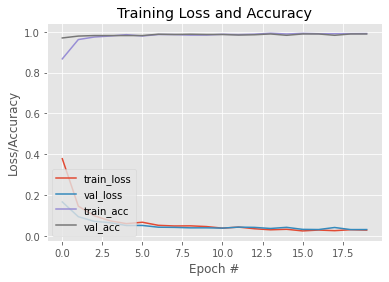

In [27]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")